In [2]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import dask_geopandas as dgpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
import xarray as xr
import rioxarray
import cdsapi
import urllib3
import cartopy.crs as ccrs
import cartopy
from matplotlib.colors import ListedColormap

# Prep roi-WBD-NAHL
Create subset version of main data file with only WBD-NAHL ROI lakes.

In [ ]:
df_HL_jn_full_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full.csv.gz'
gdf_HL_jn_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # gives ROI
df_HL_BAWLD_NAHL_jn_full_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full_jnBAWLD_roiNAHL.csv.gz' # Output: main data source # HL clipped to BAWLD and WBD


## Load, if needed
gdf_hl = pd.read_csv(df_HL_jn_full_pth, compression='gzip')
gdf_roi = gpd.read_file(gdf_HL_jn_pth) # gives indexes of lakes in ROI


/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_41832/3394725772.py:7: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf_hl = pd.read_csv(df_HL_jn_full_pth, compression='gzip')


In [ ]:
gdf_hl

,Unnamed: 0,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_sum,...,Vol_res,Dis_avg,Pour_lat,Vol_src,Country,Lake_name,system:index,Class_98,Class_99,Class_100
0,0,0.001,0.002,0.000,0.001,0.001,0.000,0.003,0.001,0.248,...,0.0,0.131,50.391481,3.0,Canada,NaN,001b0000000000004e0d,NaN,NaN,NaN
1,1,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.005,0.253,...,0.0,3.071,50.121770,3.0,Canada,NaN,001b00000000000051b5,NaN,NaN,NaN
2,2,0.003,0.000,0.000,0.001,0.001,0.001,0.000,0.003,0.363,...,0.0,0.005,50.490288,3.0,Canada,NaN,001b0000000000004c9d,NaN,NaN,NaN
3,3,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.002,0.109,...,0.0,0.001,50.485042,3.0,Canada,NaN,001b0000000000004cb5,NaN,NaN,NaN
4,4,0.001,0.000,0.001,0.001,0.000,0.000,0.003,0.003,0.154,...,0.0,0.001,50.357718,3.0,Canada,NaN,001b0000000000004e80,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112147,1112147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374,...,0.0,0.000,79.639685,3.0,Russia,NaN,001f0000000000008301,NaN,NaN,NaN
1112148,1112148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480,...,0.0,-9999.000,79.627083,3.0,Russia,NaN,001f0000000000008305,NaN,NaN,NaN
1112149,1112149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.236,...,0.0,0.695,79.532163,3.0,Russia,NaN,001f00000000000079b8,NaN,NaN,NaN
1112150,1112150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.683,...,0.0,2.251,79.580108,3.0,Russia,NaN,001f000000000000830d,NaN,NaN,NaN


In [ ]:
gdf_roi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 754832 entries, 0 to 754831
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Hylak_id    754832 non-null  int64   
 1   0-5         754832 non-null  float64 
 2   5-50        754832 non-null  float64 
 3   50-95       754832 non-null  float64 
 4   95-100      754832 non-null  float64 
 5   Class_sum   754832 non-null  float64 
 6   Shp_Area    754832 non-null  float64 
 7   BAWLDCell_  754832 non-null  int64   
 8   n           754832 non-null  int64   
 9   distance    754832 non-null  float64 
 10  feature_x   754832 non-null  float64 
 11  feature_y   754832 non-null  float64 
 12  nearest_x   754832 non-null  float64 
 13  nearest_y   754832 non-null  float64 
 14  BAWLDLong   754832 non-null  float64 
 15  BAWLDLat    754832 non-null  float64 
 16  geometry    754832 non-null  geometry
dtypes: float64(13), geometry(1), int64(3)
memory usage: 97.9 MB

In [ ]:
gdf_hl = gdf_hl.drop(columns=['Unnamed: 0', 'system:index']).merge(gdf_roi['Hylak_id'], on='Hylak_id', how='inner')

In [ ]:
gdf_hl

,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_sum,Class_8,...,Elevation,Vol_res,Dis_avg,Pour_lat,Vol_src,Country,Lake_name,Class_98,Class_99,Class_100
0,0.003,0.000,0.000,0.001,0.001,0.001,0.000,0.003,0.363,0.001,...,621.0,0.0,0.005,50.490288,3.0,Canada,NaN,NaN,NaN,NaN
1,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.002,0.109,0.001,...,630.0,0.0,0.001,50.485042,3.0,Canada,NaN,NaN,NaN,NaN
2,0.002,0.000,0.001,0.000,0.001,0.001,0.002,0.001,0.323,0.000,...,613.0,0.0,0.006,50.492419,3.0,Canada,NaN,NaN,NaN,NaN
3,0.005,0.002,0.002,0.001,0.003,0.002,0.000,0.005,0.198,0.002,...,612.0,0.0,0.004,50.498021,3.0,Canada,NaN,NaN,NaN,NaN
4,0.000,0.001,0.000,0.000,0.001,0.001,0.001,0.000,0.134,0.000,...,624.0,0.0,0.006,50.487126,3.0,Canada,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754827,0.002,0.000,0.000,0.000,0.001,0.002,0.000,0.000,0.164,0.001,...,29.0,0.0,0.037,67.556734,3.0,Canada,NaN,0.000,0.0,0.0
754828,0.000,0.000,0.001,0.001,0.002,0.002,0.000,0.000,0.140,0.001,...,32.0,0.0,0.001,67.528185,3.0,Canada,NaN,0.000,0.0,0.0
754829,0.001,0.000,0.001,0.000,0.000,0.001,0.000,0.001,0.103,0.000,...,28.0,0.0,0.001,67.522809,3.0,Canada,NaN,0.000,0.0,0.0
754830,0.000,0.000,0.000,0.003,0.001,0.001,0.000,0.001,0.226,0.000,...,20.0,0.0,0.071,67.637566,3.0,Canada,NaN,0.000,0.0,0.0


In [ ]:
## Write out large file
gdf_hl.to_csv(df_HL_BAWLD_NAHL_jn_full_pth)

# Downing plots

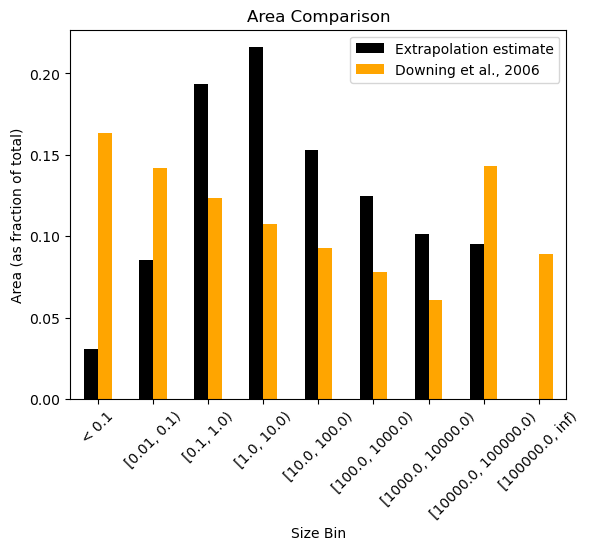

In [3]:
# Load the Excel file
df = pd.read_excel('/Users/ekyzivat/Library/CloudStorage/GoogleDrive-ethan_kyzivat@alumni.brown.edu/My Drive/Writing/Ch4/Revision1/Tables/Size_bin_table_norm_v20_Downing_save.xlsx', sheet_name='comb_bins', index_col='size_bin')

# Exclude the last row with index 'Sum'
df = df.iloc[:-1]

# Define custom colormap with black and orange
colors = ['black', 'orange']
custom_cmap = ListedColormap(colors)

# Plot the 'Area_Mkm2' and 'Downing Area norm'
fig, ax = plt.subplots()
df[['Area_Mkm2', 'Downing Area norm']].plot(kind='bar', colormap=custom_cmap, ax=ax)

# Set labels and title
ax.set_xlabel('Size Bin')
ax.set_ylabel('Area (as fraction of total)')
plt.xticks(rotation=45)
plt.title('Area Comparison')

# plt.legend(['My Arctic estimate', 'Conventional global estimate'])
plt.legend(['Extrapolation estimate', 'Downing et al., 2006'])

# Show the plot
plt.show()
